# Evaluate DINO v3 Model on PH2 dataset (never before seen data)

## Imports

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import timm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import polars as pl

from PIL import Image

from huggingface_hub import PyTorchModelHubMixin

import os

## Device

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
elif torch.backends.mps.is_available(): # For Apple Silicon
  device = torch.device("mps")
else:
  device = torch.device("cpu")


print(device)

cuda


## Important Functions

### Create Confusion Matrix

In [3]:
def _create_confusion_matrix(y, y_hat, title) -> None:
  cm = confusion_matrix(y, y_hat)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
  disp.plot(xticks_rotation='vertical', cmap='Blues')
  plt.title(title)
  plt.show()

## Data

In [4]:
class PH2Dataset(Dataset):
  """
  Dataset for PH2 images, which are in png format.

  PH2 contains skin lesions images classified as

  - Common Nevus (benign)
  - Atypical Nevus (benign)
  - Melanoma (malignant)

  No need for is real label here, since this is purely for testing
  """

  def __init__(self, dir_path, metadata, transform=None):
    super(PH2Dataset, self).__init__()

    self.dir_path = dir_path
    self.transform = transform

    self.image_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Load metadata w/ polars (only 2 columns)
    self.metadata = pl.read_csv(metadata)

    self.diagnostic_mapping = {
        "Common Nevus": 0,
        "Atypical Nevus": 0,
        "Melanoma": 1,
    }

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    # The image name in the metadata csv are like IMD003
    image_id = self.image_files[idx].split('/')[-1].split('.')[0]

    # Still need the entire path to open the image
    image = Image.open(self.image_files[idx]).convert('RGB')

    if self.transform: # Apply transform if it exists
      image = self.transform(image)

    diagnosis = self.metadata.filter(pl.col("image_name") == image_id).select("diagnosis").item()

    label = torch.tensor(self.diagnostic_mapping[diagnosis], dtype=torch.int16)

    return image, label

In [5]:
!unzip ph2_data.zip -d /content/data/

Archive:  ph2_data.zip
   creating: /content/data/ph2_data/
  inflating: /content/data/__MACOSX/._ph2_data  
   creating: /content/data/ph2_data/images/
  inflating: /content/data/__MACOSX/ph2_data/._images  
  inflating: /content/data/ph2_data/ph_2_dataset.csv  
  inflating: /content/data/__MACOSX/ph2_data/._ph_2_dataset.csv  
  inflating: /content/data/ph2_data/images/IMD389.jpg  
  inflating: /content/data/__MACOSX/ph2_data/images/._IMD389.jpg  
  inflating: /content/data/ph2_data/images/IMD404.jpg  
  inflating: /content/data/__MACOSX/ph2_data/images/._IMD404.jpg  
  inflating: /content/data/ph2_data/images/IMD376.jpg  
  inflating: /content/data/__MACOSX/ph2_data/images/._IMD376.jpg  
  inflating: /content/data/ph2_data/images/IMD410.jpg  
  inflating: /content/data/__MACOSX/ph2_data/images/._IMD410.jpg  
  inflating: /content/data/ph2_data/images/IMD160.jpg  
  inflating: /content/data/__MACOSX/ph2_data/images/._IMD160.jpg  
  inflating: /content/data/ph2_data/images/IMD014.jpg  

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Image net mean and std
    transforms.Resize((224, 224)),  # Dimensions for Efficient Net v2
])

ph_2_images = "/content/data/ph2_data/images"
ph_2_metadata = "/content/data/ph2_data/ph_2_dataset.csv"

test_dataset = PH2Dataset(ph_2_images, ph_2_metadata, transform)

In [7]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Model

In [8]:
class DinoSkinLesionClassifier(nn.Module, PyTorchModelHubMixin):
  """
  PytorchModelHubMixin adds push to Hugging Face Hub

  See: https://huggingface.co/docs/hub/models-uploading#upload-a-pytorch-model-using-huggingfacehub
  """
  def __init__(self, num_classes=1, freeze_backbone=True):
    super(DinoSkinLesionClassifier, self).__init__()

    # Initialize Dino v3 backbone
    self.backbone = timm.create_model('vit_base_patch16_dinov3', pretrained=True, num_classes=0, global_pool='avg')

    # Freeze backbone weights if requested
    # This makes training much faster
    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

    # Get feature dimension from the backbone
    feat_dim = self.backbone.num_features

    # Define the classification head
    self.head = nn.Linear(feat_dim, num_classes) # Should be 768 in, 1 out

  def forward(self, x):
    out = self.backbone(x)
    out = self.head(out)

    return out

In [9]:
from huggingface_hub import hf_hub_download

weights_path = hf_hub_download(
        repo_id="avanishd/vit-base-patch16-dinov3-finetuned-skin-lesion-classification",
        filename="model.safetensors"
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [10]:
from safetensors.torch import load_file

model = DinoSkinLesionClassifier()
state = load_file(weights_path)
model.load_state_dict(state, strict=True)

model.eval()  # Set model to evaluation mode

model.to(device) # Don't forget to put on GPU

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

DinoSkinLesionClassifier(
  (backbone): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingDinoV3()
    (norm_pre): Identity()
    (blocks): ModuleList(
      (0-11): 12 x EvaBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): EvaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act)

## Evaluation

In [11]:
def _generate_test_predictions(model, test_loader) -> tuple[list, list]:
  """
  Use trained model to generate predictions on test dataset
  """

  # Pre-allocate arrays based on test set size
  # This is more efficient b/c it reduces memory copies
  test_size = len(test_loader.dataset)
  y_pred_array = np.zeros(test_size)
  y_target_array = np.zeros(test_size)

  batch_store = [] # For Grad CAM
  model.eval()
  #Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
  # reduces memory usage and speeds up computation
  with torch.no_grad():
      start_idx = 0
      for (images, labels) in test_loader:
        batch_size = images.size(0)

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)

        # Need to sigmoid output to use for pAUC
        y_pred = torch.sigmoid(output).cpu().numpy().ravel()
        y_pred = np.where(y_pred < 0.5, 0, 1)
        y_true = labels.cpu().numpy().ravel()

        # Directly place values in pre-allocated arrays
        end_idx = start_idx + batch_size
        y_pred_array[start_idx:end_idx] = y_pred
        y_target_array[start_idx:end_idx] = y_true

        # Get predictions for Grad CAM
        images_cpu = images.cpu()
        labels_cpu = labels.cpu().numpy()
        y_pred_prob = np.where(y_pred < 0.5, 0, 1)
        batch_store.append((images_cpu, y_pred_prob, labels_cpu))

        start_idx = end_idx

  return y_pred_array, y_target_array, batch_store

In [12]:
dino_test_pred, dino_test_target, dino_batch_store = _generate_test_predictions(model, test_loader)

## Confusion Matrix

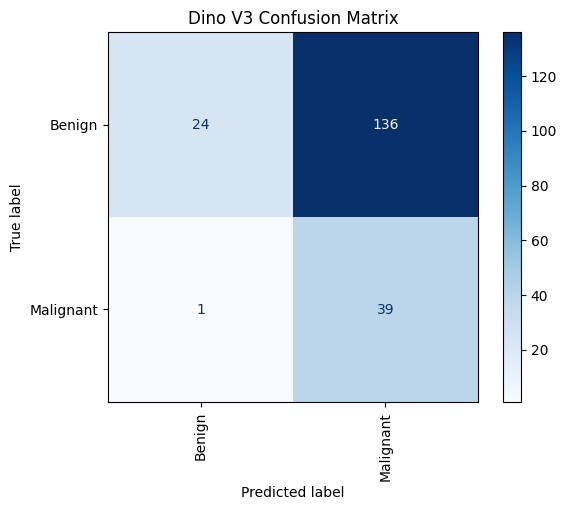

In [13]:
dino_test_pred = np.where(dino_test_pred < 0.5, 0, 1)

_create_confusion_matrix(dino_test_target, dino_test_pred, "Dino V3 Confusion Matrix")

## GRAD Cam

In [14]:
%pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=98fa7c4e3b71755036d41a79a3642875cfe2ae51d0e361b7ed44ca6576ac2869
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [22]:
def _select_confusion_examples(batch_store):
  examples = {
    "true_negative": None,
    "false_negative": None,
    "true_positive": None,
    "false_positive": None
  }

  for images, preds, labels in batch_store:
        cases = {
            "true_negative": (preds == 0) & (labels == 0),
            "false_negative": (preds == 0) & (labels == 1),
            "true_positive": (preds == 1) & (labels == 1),
            "false_positive": (preds == 1) & (labels == 0),
        }

        for key, mask in cases.items():
            if examples[key] is None and mask.any():
                idx = np.argmax(mask)
                examples[key] = (
                    images[idx:idx+1],
                    int(preds[idx]),
                    int(labels[idx])
                )

        # stop early if all found
        if all(v is not None for v in examples.values()):
            break

  return examples

In [53]:
# See: https://github.com/jacobgil/pytorch-grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget # Changed back to ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.backbone.patch_embed.proj]

input_tensor, _ = next(iter(test_loader))
input_tensor = input_tensor[0:1].to(device) # Select first image and keep batch dim

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])


def _generate_cam_image(input_tensor, target_class_idx):

  # Temporarily override the model's forward method to return two logits for GradCAM
  original_forward = model.forward
  def custom_forward(x):
      single_logit = original_forward(x) # Original model outputs a single logit
      # Create two logits: one for class 0 (negative logit) and one for class 1 (positive logit)
      return torch.cat([-single_logit, single_logit], dim=1)

  model.forward = custom_forward

  targets = [ClassifierOutputTarget(target_class_idx)] # Now use ClassifierOutputTarget for 2 outputs

  with GradCAM(model=model, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0]

  # Restore the original forward method
  model.forward = original_forward

  # Convert from tensor to np.ndarray
  input_image_np = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

  # Un-normalize the image to restore original colors
  unnormalized_image = input_image_np * IMAGENET_STD + IMAGENET_MEAN

  # Clip values to be in the [0, 1] range to avoid display artifacts
  unnormalized_image = np.clip(unnormalized_image, 0, 1)

  # Create the visualization
  visualization = show_cam_on_image(unnormalized_image, grayscale_cam, use_rgb=True)

  return visualization

In [54]:
# CAM image for each of TN, FN, TP, FP
examples = _select_confusion_examples(dino_batch_store)
visualizations = {}

# Set requires_grad=True so Grad CAM can work
# Not using model after this, so it's fine
for param in model.parameters(): # Updated target layer for requires_grad
    param.requires_grad = True

for case_name, data in examples.items():
    if data is not None:
        input_tensor, pred, label = data
        visualizations[case_name] = _generate_cam_image(input_tensor, pred)

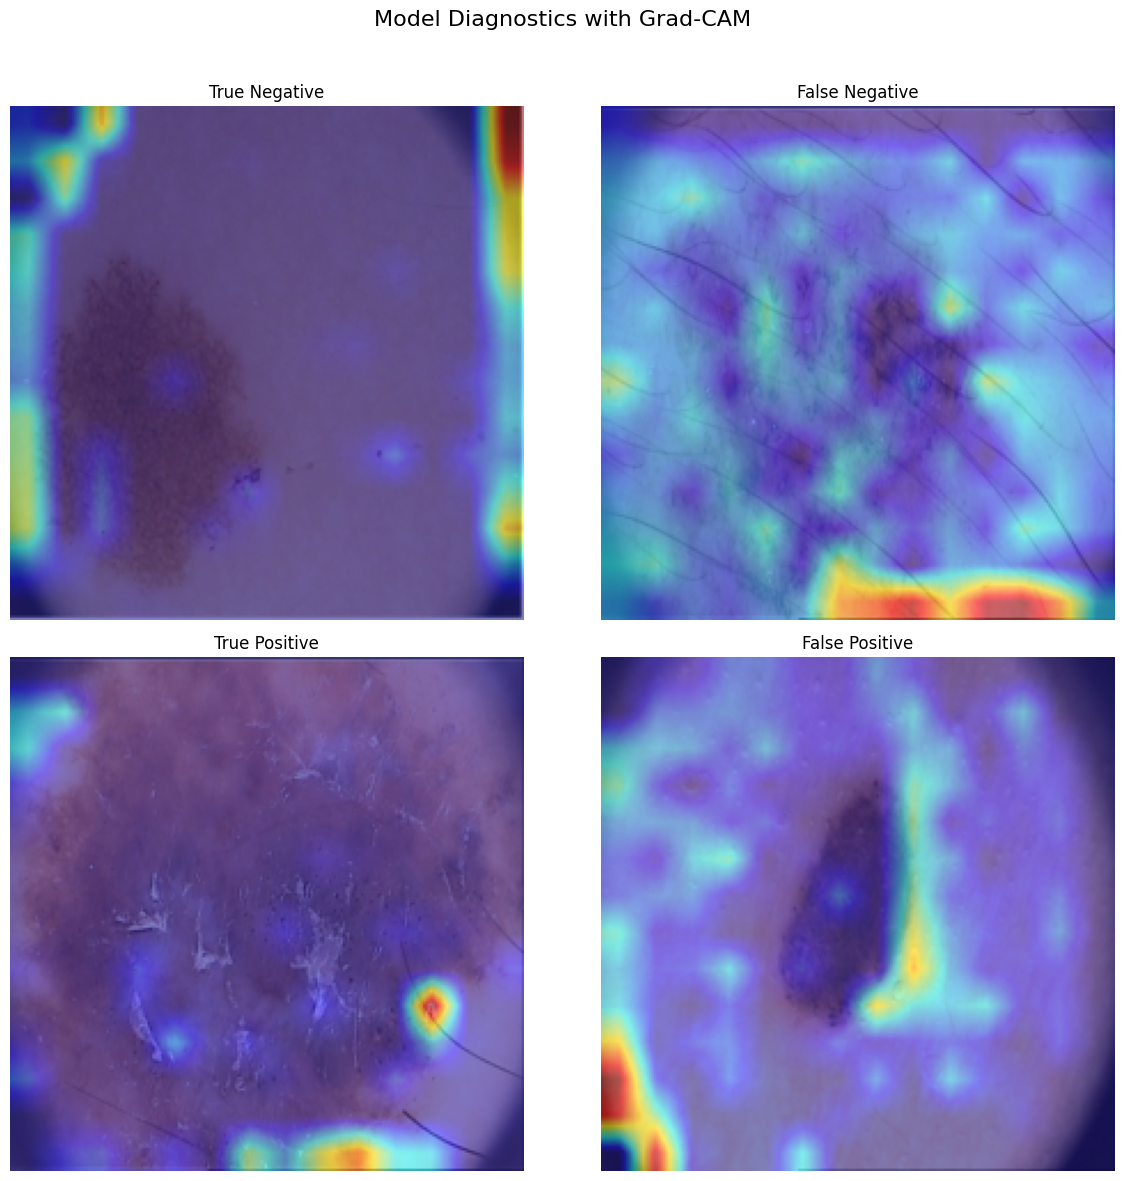

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Model Diagnostics with Grad-CAM", fontsize=16)

# Mapping for subplot positions and titles
plot_map = {
    "true_negative": (axes[0, 0], "True Negative"),
    "false_negative": (axes[0, 1], "False Negative"),
    "true_positive": (axes[1, 0], "True Positive"),
    "false_positive": (axes[1, 1], "False Positive")
}

for case_name, (ax, title) in plot_map.items():
    if case_name in visualizations:
        ax.imshow(visualizations[case_name])
        ax.set_title(title, fontsize=12)
    else:
        ax.text(0.5, 0.5, 'Example\nNot Found', ha='center', va='center', fontsize=12)
        ax.set_title(f"{title} (N/A)", fontsize=12)

    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()